<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Нейросеть" data-toc-modified-id="Нейросеть-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Нейросеть</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#LGBM" data-toc-modified-id="LGBM-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>LGBM</a></span></li><li><span><a href="#Сравнение-моделей" data-toc-modified-id="Сравнение-моделей-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Сравнение моделей</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Выполнение проекта будет осуществляться в несколько этапов:
1. Импорт нужных библиотек и загрузка данных
2. Анализ данных, определение тестами необходимых признаков для максимальной эффективности будущей модели
3. Обучение и валидация гиперпараметров модели на полученом датасете
4. Повторное обучение и тестирование полученного варианта нейросети

## Подготовка

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from math import ceil

In [210]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
data.sort_index(inplace=True)


## Анализ

In [211]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Данные представляют из себя серию с объемом заказов такси с шагом в 10 минут. Задача стоит в предсказании объема на следующий час, соответственно, данные нужно ресемплировать.

In [212]:
data = data.resample('1H').sum()

In [213]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


Пропусков нет.

Проверим индексы на монотонность.

In [214]:
data.index.is_monotonic

True

Пропусков в индексах нет, и он монотонно возрастает

In [215]:
print(f'Период c {data.index.min()} по {data.index.max()}')

Период c 2018-03-01 00:00:00 по 2018-08-31 23:00:00


Посмотрим данные на графике, а также нарисуем графики скользящего среднего и стандартного отклонения 

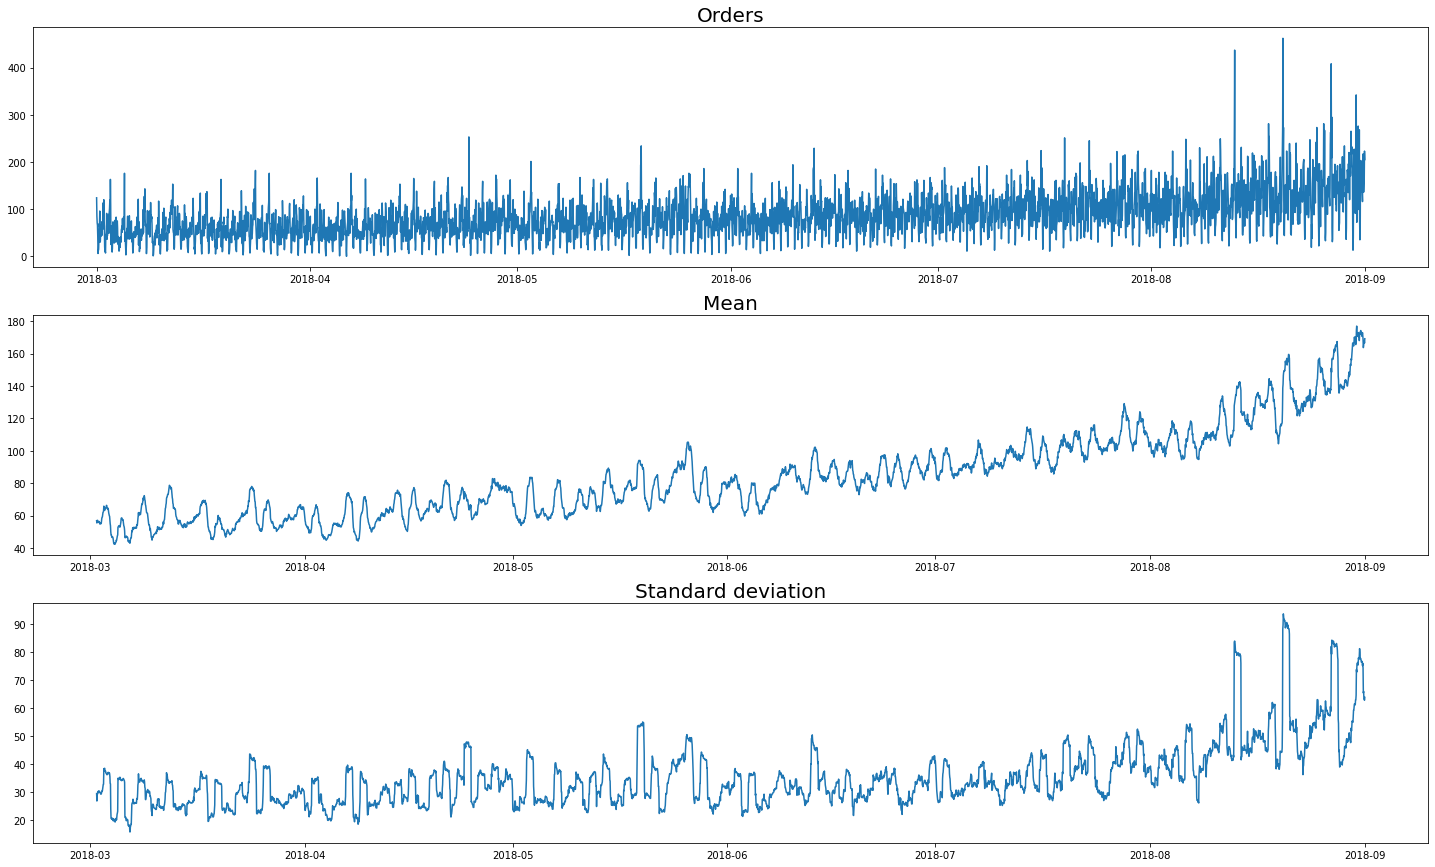

In [216]:
fig, ax = plt.subplots(3, 1, figsize=(25,15))
ax[0].plot(data.index, data)
ax[0].set_title('Orders', fontsize=20)
ax[1].plot(data.index, data.shift().rolling(24).mean())
ax[1].set_title('Mean', fontsize=20)
ax[2].plot(data.index, data.shift().rolling(24).std())
ax[2].set_title('Standard deviation', fontsize=20)
plt.show()

Ряд не стационарен: и среднее и стандартное отклонение не постоянны, есть выбросы. 

Разложим временной ряд. Тренд видится постоянным, сезонности по временам года не видно.

Для наглядности ресемплируем данные до 1 дня

In [217]:
decomposed = seasonal_decompose(data.resample('1D').sum())

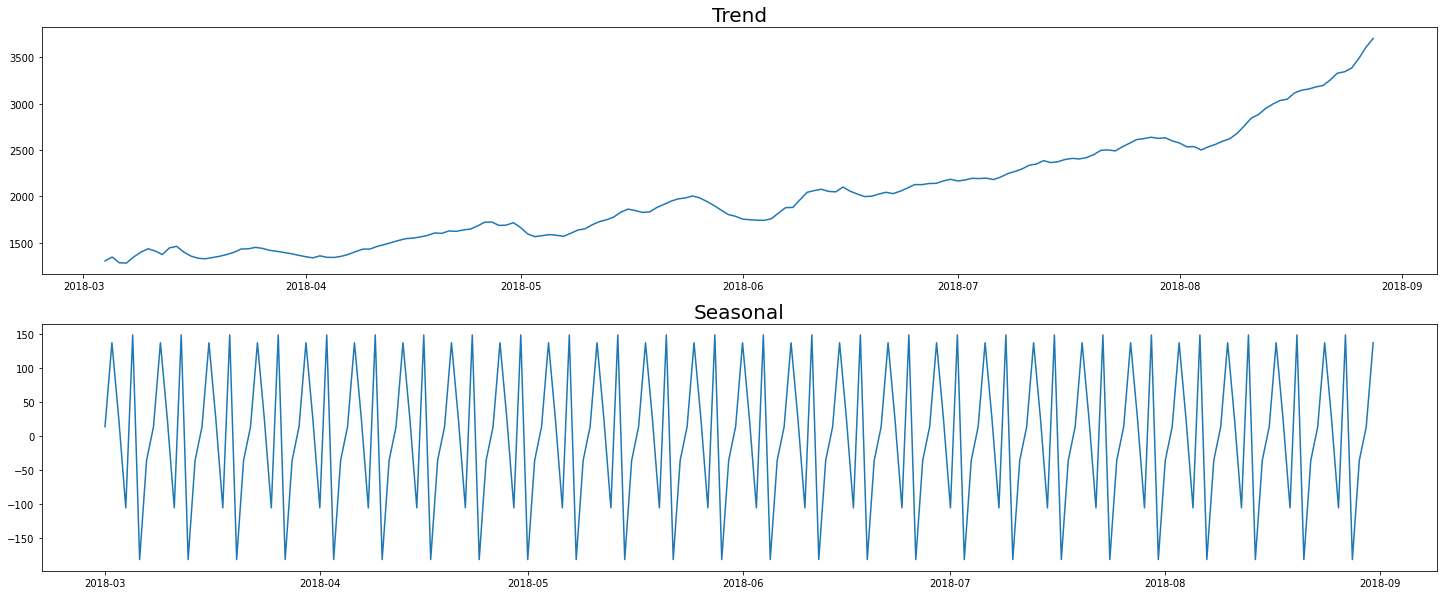

In [218]:
fig, ax = plt.subplots(2, 1, figsize=(25,10))
ax[0].plot(decomposed.trend.index, decomposed.trend)
ax[0].set_title('Trend', fontsize=20)
ax[1].plot(decomposed.seasonal.index, decomposed.seasonal)
ax[1].set_title('Seasonal', fontsize=20)
plt.show()

Тренд постоянный. Видна четкая недельная сезонность.

Теперь проверим суточную сезонность. Для этого возьмем почасовые данные за один месяц.

In [219]:
decomposed = seasonal_decompose(data['2018-06-01':'2018-06-15'])

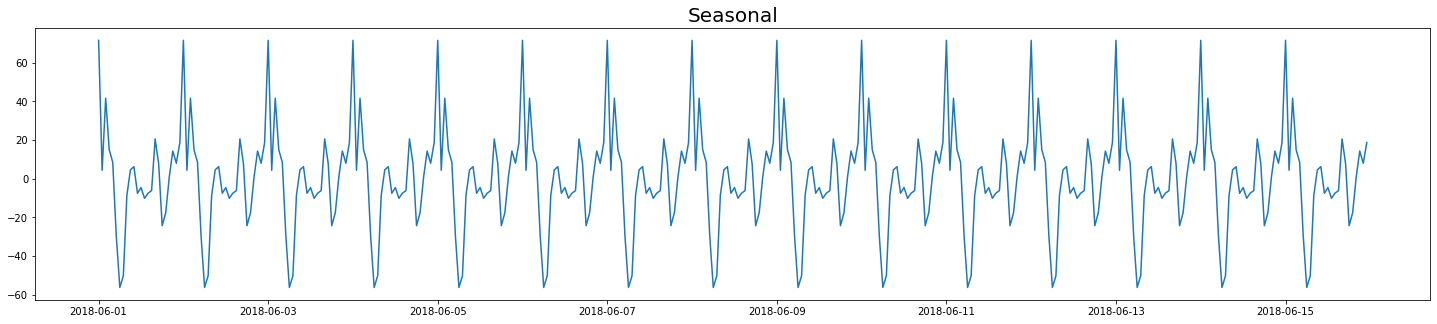

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(25,5))
ax.plot(decomposed.seasonal.index, decomposed.seasonal)
ax.set_title('Seasonal', fontsize=20)
plt.show()

**Вывод**

Необходимо выделить в датасет обозночение часа (т.к. это целевой интервал предсказания) и, исходя из наблюдаемой недельной сезонности, день недели.

С помощью скользящей средней нужно включить в расчет влияние тренда.

## Обучение

Создадим функцию, которая добавит несколько фичей: час и день недели, в соответствии с наблюдаемой сезонностью, дельту с предыдущим измерением для стационарности ряда, временной лаг на 12 часов, и скользящую среднюю с периодом в 72 часа.

In [221]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    data['delta']=data['num_orders'].shift(1)-data['num_orders'].shift(2)
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [222]:
make_features(data, 12, 72)

In [223]:
data.head()

,num_orders,hour,dayofweek,delta,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,rolling_mean
datetime,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,-39.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,-14.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,-5.0,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Удалим строки с NaN

In [224]:
data.dropna(inplace=True)

В качестве бейзлайна возьмем предыдущие значения

In [225]:
baseline_y = data['num_orders'].shift(1)

Разобьем данные на учебную, валидационную и тестовую выборки.

In [226]:
def y_extract(data, y_name, size=0, shuffle=False): #выделение из датасета целевого признака и разбиение данных на учебную и валидационную
    target = data[y_name]
    features = data.drop(y_name, axis=1)
    if size>0:
        X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size = size, random_state = 777, shuffle=shuffle)
        return X_train, X_valid, y_train, y_valid
    else: 
        return features, target

In [227]:
X_train, X_test, y_train, y_test = y_extract(data, 'num_orders', .1)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = .1, random_state = 777, shuffle=False)

In [228]:
print(X_tr.index.min(), X_tr.index.max())
print(X_val.index.min(), X_val.index.max())
print(X_test.index.min(), X_test.index.max())

2018-03-04 00:00:00 2018-07-28 13:00:00
2018-07-28 14:00:00 2018-08-13 20:00:00
2018-08-13 21:00:00 2018-08-31 23:00:00


Трансформируем категориальные признаки и проскалируем численные.

In [229]:
cat_col = ['hour', 'dayofweek']
num_col = X_tr.columns.drop(cat_col)

In [230]:
scaler = StandardScaler().fit(X_tr[num_col])
ohe = OneHotEncoder().fit(X_tr[cat_col])

In [231]:
def ohe_transform(data, ohe, f_names):
    new_data=data.copy()
    ohe_data = pd.DataFrame(ohe.transform(new_data[f_names]).toarray(), columns=ohe.get_feature_names(f_names), index=data.index)
    new_data.drop(f_names, axis=1, inplace=True)
    return pd.concat([new_data, ohe_data], axis=1)

In [232]:
X_tr[num_col] = scaler.transform(X_tr[num_col])
X_tr = ohe_transform(X_tr, ohe, cat_col)

X_val[num_col] = scaler.transform(X_val[num_col])
X_val = ohe_transform(X_val, ohe, cat_col)

X_test[num_col] = scaler.transform(X_test[num_col])
X_test = ohe_transform(X_test, ohe, cat_col)

X_train[num_col] = scaler.transform(X_train[num_col])
X_train = ohe_transform(X_train, ohe, cat_col)

/tmp/ipykernel_31/334067806.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_tr[num_col] = scaler.transform(X_tr[num_col])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/334067806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docu

In [233]:
cat_col = X_tr.columns.drop(num_col) #сохраним обновленный список категориальных признаков для передачи в бустинг

Данные готовы к обучению и тестированию

### Нейросеть

Для нейросети переведем данные в тензор

In [234]:
train_data_torch = torch.FloatTensor(np.array(X_tr))
train_data_full_torch = torch.FloatTensor(np.array(X_train))
val_data_torch = torch.FloatTensor(np.array(X_val))
test_data_torch = torch.FloatTensor(np.array(X_test))
y_tr_torch = torch.FloatTensor(y_tr)
y_train_torch = torch.FloatTensor(y_train)
y_val_torch = torch.FloatTensor(y_val)
y_test_torch = torch.FloatTensor(y_test)

In [235]:
class CustomEarlyStopping(): 
# класс для проверки изменения целевой метрики. 
# Если она долго не меняется, или меняется незначительно, то обучение прерывается
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            #print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                #print('INFO: Early stopping')
                self.early_stop = True

In [236]:
class MyNN(): 
    
    def __init__(self, neurons, afunc, reg='', dop=[]):
        self.neurons = neurons
        self.neurons.append(1) # добавим слой на выхо
        self.afunc = afunc # массив с функцией активации
        self.net_layers = []
        self.reg = reg
        self.dop = dop
        self.net = self.construct_net()
        self.net.apply(self.init_weights)
        
        
    def construct_net(self):
        for i in range(1, len(self.neurons) - 1):
            self.net_layers.append(nn.Linear(self.neurons[i-1], self.neurons[i]))
            self.net_layers.append(self.afunc[i-1])
            if self.reg == 'bn': self.net_layers.append(nn.BatchNorm1d(self.neurons[i]))
            if self.reg == 'do': self.net_layers.append(nn.Dropout(dop[i-1]))
        self.net_layers.append(nn.Linear(self.neurons[-2], self.neurons[-1]))
        self.net_layers.append(self.afunc[-1])
        net = nn.Sequential(*self.net_layers)
        return net
    
    def init_weights(self, layer):
        if type(layer) == nn.Linear:
            nn.init.kaiming_uniform_(layer.weight, mode="fan_out", nonlinearity="relu")

In [237]:
def learning_curve(scores):
    plt.plot(scores['rmse_train'], color = 'red', label = 'Train')
    plt.plot(scores['rmse_test'], label = 'Test')
    plt.legend()
    plt.show()

In [238]:
def new_layer(neur, afunc, X_t, X_v, y_t, y_v, in_rmse=0, check = False, reg=None, dop = 0, epochs = 5000, metr=0):
    n = neur.copy()
    b_rmse = in_rmse
    score = []
    opt_epoch = 0
    vis = False

    loss = nn.MSELoss()
    model_nn = MyNN(n, afunc, loss)
    optimizer = torch.optim.Adam(model_nn.net.parameters(), lr=1e-3)    
    num_epochs = epochs
    
    early_stopping = CustomEarlyStopping(patience=1000, min_delta=.02) 
    #для проверки процесса обучения оставим 1000 эпох и .02 RMSE шага изменений
    
    for epch in range(num_epochs):
        early_stopping(b_rmse)
        if early_stopping.early_stop:
            break #изменений нет
        model_nn.net.train()
        optimizer.zero_grad()
        preds = model_nn.net.forward(X_t).flatten()
        loss_value = loss(preds, y_t).float()
        loss_value.backward()
        optimizer.step()
            
        if epch % 100 == 0 or epch == num_epochs - 1:
            with torch.no_grad():
                model_nn.net.eval()
                test_preds = model_nn.net.forward(X_v)
                rmse_test = mean_squared_error(test_preds.detach().numpy(), y_v.detach().numpy())**.5
                if rmse_test < b_rmse:
                    b_rmse = rmse_test
                    opt_epoch = epch
                    if b_rmse < metr:
                        vis = True
                if check:
                    train_preds = model_nn.net.forward(X_t)
                    rmse_train = mean_squared_error(train_preds.detach().numpy(), y_t.detach().numpy())**.5
                    score.append([rmse_train, rmse_test])
    if vis and check:
        score = pd.DataFrame(score, columns=['rmse_train', 'rmse_test'])
        learning_curve(score)
        print(n, b_rmse)
        print("___________________________")
    return b_rmse, opt_epoch

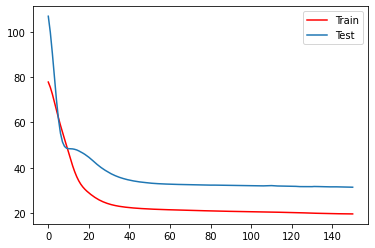

[45, 4, 1] 31.44040334350601
___________________________


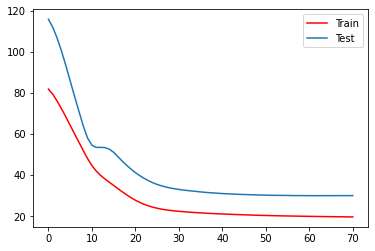

[45, 8, 1] 29.880757690791263
___________________________


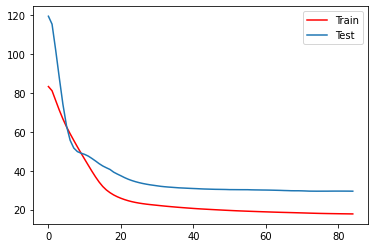

[45, 12, 1] 29.462449825278128
___________________________


In [239]:

in_n = train_data_torch.size()[1]
net_var=[] #массив для хранения структуры сети
temp_net_var=[]
neurons = 0
nneu=[] #временный массив для хранения структуры сети
epochs=0
nneu.append(in_n)
rmse=20000

for hid_n in np.arange(len(nneu),11): #сеть с 10 скрытыми слоями
    for l in np.arange(len(nneu)-1,hid_n):
        local_rmse=20000
        for i in np.arange(4, 41, 4): # от 4 до 40 нейронов в слое
            temp_rmse=20000
            n_neu=nneu.copy()
            n_neu.append(i)
            function = np.full(len(n_neu)+1, nn.ReLU()) #ф-цию активации везде проставим ReLu
            rmse_n, ep = new_layer(n_neu, function, train_data_torch, val_data_torch, y_tr_torch, y_val_torch, 
                                    temp_rmse, epochs = 15000, check=True, metr=rmse)
            if rmse_n < local_rmse:
                local_rmse = rmse_n
                neurons = i
                temp_net_var = n_neu.copy()
            if rmse_n < rmse:
                rmse = rmse_n
                epochs = ep
                net_var = n_neu.copy()
    nneu.append(neurons)

In [240]:

print(net_var)
print(epochs)
print(rmse)


[45, 12]
8400
29.462449825278128


Брутфорс показал, что увеличение количества слоев не оказывает заметного влияния на результаты.

Стоит попробовать сети в виде пирамиды с 2-3 слоями и большим количеством нейронов, вроде: [1024, 512, 256], [512, 128, 32] и т.д.

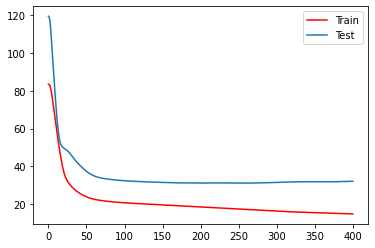

rmse_train    14.764487
rmse_test     32.049922
Name: 400, dtype: float64


In [241]:
nv = [45, 32, 16]
af_list = np.full(len(nv), nn.ReLU())
loss = nn.MSELoss()
model_nn = MyNN(nv, af_list, loss)
optimizer = torch.optim.Adam(model_nn.net.parameters(), lr=1e-3)    
score=[]

for epch in range(4000):
    model_nn.net.train()
    optimizer.zero_grad()
    preds = model_nn.net.forward(train_data_torch).flatten()
    loss_value = loss(preds, y_tr_torch).float()
    loss_value.backward()
    optimizer.step()
    if epch % 10 == 0 or epch == 4000 - 1:
            with torch.no_grad():
                model_nn.net.eval()
                test_preds = model_nn.net.forward(val_data_torch)
                rmse_test = mean_squared_error(test_preds.detach().numpy(), y_val_torch.detach().numpy())**.5
                train_preds = model_nn.net.forward(train_data_torch)
                rmse_train = mean_squared_error(train_preds.detach().numpy(), y_tr_torch.detach().numpy())**.5
                score.append([rmse_train, rmse_test])
score = pd.DataFrame(score, columns=['rmse_train', 'rmse_test'])
learning_curve(score)
print(score.iloc[-1])

В итоге, выросло только время выполнения, остановимся на предыдущем результате.

Обучим нейросеть на всех тренировочных данных перед проведением теста.

In [242]:
loss = nn.MSELoss()
model_nn = MyNN(net_var, af_list, loss)
optimizer = torch.optim.Adam(model_nn.net.parameters(), lr=1e-3)    


for epch in range(epochs):
    model_nn.net.train()
    optimizer.zero_grad()
    preds = model_nn.net.forward(train_data_full_torch).flatten()
    loss_value = loss(preds, y_train_torch).float()
    loss_value.backward()
    optimizer.step()


Обучим ещё пару моделей для сравнения результатов.

### Линейная регрессия

In [243]:
lr = LinearRegression()

In [244]:
lr.fit(X_tr, y_tr) 

LinearRegression()

In [245]:
pred_lr=lr.predict(X_val)

In [246]:
lr.fit(X_train, y_train) 

LinearRegression()

### LGBM

In [247]:
param_grid_lgbm = {
    'num_leaves': np.arange(2, 21, 2),
    'max_depth': np.arange(1, 21, 5),
    'min_data_in_leaf': [10, 20, 30, 50, 100, 300],
    'learning_rate': [0.1],
    'verbose': [-1]
    }
fit_params = {'categorical_feature':cat_col.tolist(),'verbose':-1}

In [248]:
lgbm = LGBMRegressor()

In [249]:
tscv = TimeSeriesSplit(n_splits=5)

In [250]:
%%capture
gsearch_lgbm = GridSearchCV(estimator=lgbm, param_grid=param_grid_lgbm, cv=tscv, scoring='neg_mean_squared_error')
gsearch_lgbm.fit(X_train, y_train, **fit_params)

In [251]:
param_lgbm = gsearch_lgbm.best_params_

In [252]:
lgbm = LGBMRegressor(**param_lgbm)

In [253]:
lgbm.fit(X_tr, y_tr, categorical_feature=cat_col.tolist())

/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


LGBMRegressor(max_depth=11, min_data_in_leaf=10, num_leaves=8, verbose=-1)

In [254]:
pred_lgbm=lgbm.predict(X_val)

In [255]:
lgbm.fit(X_train, y_train, categorical_feature=cat_col.tolist())

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


LGBMRegressor(max_depth=11, min_data_in_leaf=10, num_leaves=8, verbose=-1)

### Сравнение моделей

In [256]:
print("Neur RMSE", rmse)
print("Linear RMSE", mean_squared_error(pred_lr, y_val)**.5)
print("LGBM RMSE", mean_squared_error(pred_lgbm, y_val)**.5)

Neur RMSE 29.462449825278128
Linear RMSE 32.22744784138421
LGBM RMSE 31.863947737842405


## Тестирование

Проведем тестирование полученных моделей. За бейзлайн возьмем предыдущее значение ряда.

In [257]:
model_nn.net.eval()
test_preds = model_nn.net.forward(test_data_torch)
rmse_test = mean_squared_error(test_preds.detach().numpy(), y_test_torch.detach().numpy())**.5

In [258]:
pred_lr=lr.predict(X_test)
pred_lgbm=lgbm.predict(X_test)

In [259]:
print("Neur RMSE", rmse_test)
print("Linear RMSE", mean_squared_error(pred_lr, y_test)**.5)
print("LGBM RMSE", mean_squared_error(pred_lgbm, y_test)**.5)
print("Baseline RMSE", mean_squared_error(baseline_y[y_test.index], y_test)**.5)
print("Mean", y_test.mean())
print("Standard deviation", y_test.std())

Neur RMSE 38.75418481687252
Linear RMSE 42.077771214822114
LGBM RMSE 41.98199504866392
Baseline RMSE 59.149702926742066
Mean 139.84827586206896
Standard deviation 58.895126393608464


Нейросеть показала в результате среднеквадратичную ошибку равной 38.75, что значительно ниже бейзлайна со смещением (59.15), который, в свою очередь, близок по значению к стандартному отклонению за тот же период. Это говорит, что модель адекватна, и с поставленной задачей справляется.